In [1]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import shutil


**LOADING** **THE** **DATA** **SET** **FROM** **KAGGLE**

In [4]:

!mkdir ~/.kaggle
!cp kaggle (2).json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle (2).json

# Example: Replace username/dataset with the Kaggle dataset name
!kaggle datasets download -d yasserhessein/gender-dataset --unzip -p /content/dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `cp kaggle (2).json ~/.kaggle/'
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `chmod 600 ~/.kaggle/kaggle (2).json'
Dataset URL: https://www.kaggle.com/datasets/yasserhessein/gender-dataset
License(s): unknown
 99% 1.31G/1.32G [00:07<00:00, 136MB/s]
100% 1.32G/1.32G [00:07<00:00, 186MB/s]


since the datset is very large we shall have to make a samller dataset so i have decided to take first 1000 images after shuffling to ensure randomness as well

In [5]:
base_dataset_path = '/content/dataset/Dataset'


train_male_path = os.path.join(base_dataset_path, 'Train', 'Male')
train_female_path = os.path.join(base_dataset_path, 'Train', 'Female')

# Storing the sampled dataset in a new folder
sampled_train_path = '/content/sampled_train'
sampled_male_path = os.path.join(sampled_train_path, 'Male')
sampled_female_path = os.path.join(sampled_train_path, 'Female')

# Create directories for sampled data
os.makedirs(sampled_male_path, exist_ok=True)
os.makedirs(sampled_female_path, exist_ok=True)
male_images = os.listdir(train_male_path)
random.shuffle(male_images)  # Shuffle to randomize
for img in male_images[:1000]:  # Take the first 1000 after shuffling
    shutil.copy(os.path.join(train_male_path, img), os.path.join(sampled_male_path, img))

# Sample Female images
female_images = os.listdir(train_female_path)
random.shuffle(female_images)  # Shuffle to randomize
for img in female_images[:1000]:  # Take the first 1000 after shuffling
    shutil.copy(os.path.join(train_female_path, img), os.path.join(sampled_female_path, img))

print("Sampling complete!")
print(f"Male images sampled: {len(os.listdir(sampled_male_path))}")
print(f"Female images sampled: {len(os.listdir(sampled_female_path))}")

Sampling complete!
Male images sampled: 1000
Female images sampled: 1000


In [6]:
train_dir = '/content/sampled_train'

loading the haar cascade model for object detection

In [7]:
# Load the pre-trained Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

**PRE** **PROCESSING** **THE** **SAMPLES**

In [8]:
def detect_and_crop_face(image_path, target_size=(150, 150)):
    # Loading the image
    img = cv2.imread(image_path)
    # Converting into grayscale as HAAR CASCADE is designed to detect gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detection of faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) > 0:  # If faces are found
        # Crop the first detected face
        x, y, w, h = faces[0]
        cropped_face = img[y:y+h, x:x+w]  # Crop the face region

        # Resize the cropped face to the target size
        cropped_face_resized = cv2.resize(cropped_face, target_size)

        return cropped_face_resized
    else:
        return None


In [9]:
train_male_path = '/content/sampled_train/Male' #to apply labels
train_female_path = '/content/sampled_train/Female'

def process_images(data_dir, label, target_folder):
    face_images = []
    labels = []

    # Going through all images in my directory
    for img_name in os.listdir(data_dir):
        img_path = os.path.join(data_dir, img_name)

        # Detect and crop face
        cropped_face = detect_and_crop_face(img_path)

        if cropped_face is not None:
            # Save the cropped face
            save_path = os.path.join(target_folder, str(label), img_name)
            cv2.imwrite(save_path, cropped_face)
            face_images.append(cropped_face)
            labels.append(label)

    return face_images, labels

# Create target directories for cropped images
os.makedirs('/content/cropped_faces/Male', exist_ok=True)
os.makedirs('/content/cropped_faces/Female', exist_ok=True)

# Process Male and Female images
male_faces, male_labels = process_images(train_male_path, 0, '/content/cropped_faces/Male')  # Label Male as 0
female_faces, female_labels = process_images(train_female_path, 1, '/content/cropped_faces/Female')  # Label Female as 1

# Combine the male and female data
faces = male_faces + female_faces
labels = male_labels + female_labels


faces = np.array(faces)
labels = np.array(labels)

# Normalize image data
faces = faces / 255.0


# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(faces, labels, test_size=0.2, random_state=42)

# Reshaping the data
X_train = X_train.reshape(X_train.shape[0], 150, 150, 3)
X_val = X_val.reshape(X_val.shape[0], 150, 150, 3)

**BUILDING** **THE** **MODEL**

In [10]:
model = Sequential([
    # Convolutional and pooling layers
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten and fully connected layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout for regularization
    Dense(1, activation='sigmoid')  # Output layer with sigmoid for binary classification (Male/Female)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Training
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.5264 - loss: 0.7708 - val_accuracy: 0.6385 - val_loss: 0.6252
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6831 - loss: 0.5985 - val_accuracy: 0.7652 - val_loss: 0.4884
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7838 - loss: 0.4673 - val_accuracy: 0.8575 - val_loss: 0.3526
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8585 - loss: 0.3610 - val_accuracy: 0.8391 - val_loss: 0.3544
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8708 - loss: 0.3168 - val_accuracy: 0.8813 - val_loss: 0.2638
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8989 - loss: 0.2413 - val_accuracy: 0.8918 - val_loss: 0.2547
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9300 - loss: 0.1795 - val_accuracy: 0.8813 - val_loss: 0.2843
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9083 - loss: 0.2300 - val_accuracy: 0.8813 - val_loss:

In [13]:
from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/MyDrive/gender_detection_model.keras')
#saving my model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**CALCULATING** **AND** **PLOTTING** **THE** **VALIDATION** **ACCURACY**

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 521ms/step - accuracy: 0.8895 - loss: 0.2896
Validation Accuracy: 88.65%


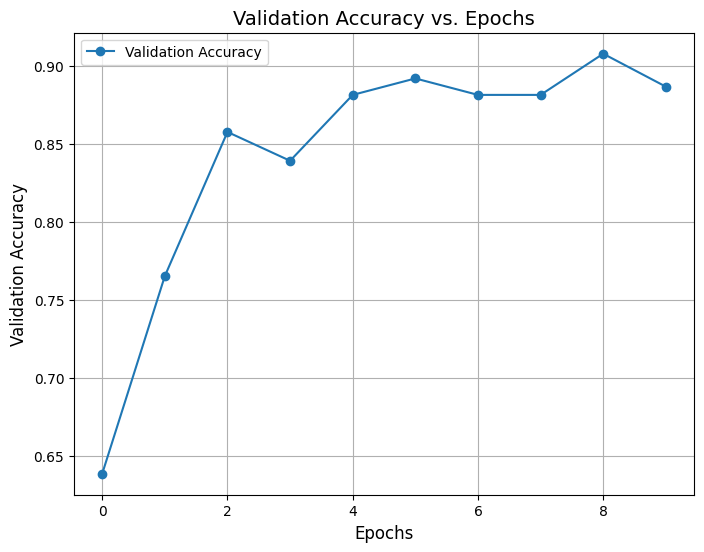

In [14]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/gender_detection_model.keras')

# Evaluate the loaded model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
import matplotlib.pyplot as plt

# Access the validation accuracy from the training history
val_accuracy_history = history.history['val_accuracy']

epochs = range(10)  # Since I have trained for 10 Epochs
plt.figure(figsize=(8, 6))

# Plotting the validation accuracy vs Epochs graph
plt.plot(epochs, val_accuracy_history, label='Validation Accuracy', marker='o')

plt.title('Validation Accuracy vs. Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()